y_pred =  [13.328 18.715 10.705 15.921 24.491  7.507 30.874 26.469 23.839 22.594
 21.083 17.346 26.843 20.129 20.574 18.667 13.495 17.346 20.526 10.129
 26.607  8.113 11.672 24.797 21.798 11.202  8.66  19.751 25.397 32.305
 13.253 21.747 27.073 16.927 18.619 23.585 17.125 15.001 28.338 33.378
 12.485 18.493 14.617 10.812 17.205 20.536 24.92  15.64  20.162 14.689
  8.376 10.992  8.148 18.618 19.18   9.726 14.195 18.478 32.479  7.546
 21.333 20.403 10.981 24.253 33.686 26.761 26.069 13.167  7.811 28.206
 16.979 25.368 17.68  19.374 15.861 32.059 10.564 19.52  30.641 32.082
 12.915 15.533 16.178 21.919 18.638 13.366 14.52  18.616 22.292 10.863
 32.173 24.307 16.79  24.418 15.903 28.697 28.671 19.03  26.563 21.735
 17.135 26.86  14.108 10.064 10.982 30.035 15.12 ]
y_test =  [13.8 19.2 11.1 16.2 19.   8.1 30.7 27.4 24.2 22.3 22.2 15.6 28.2 21.5
 20.  18.8 13.8 17.2 19.2 10.8 27.   8.7 12.3 25.1 22.2 11.2  9.5 20.
 25.1 31.8 13.6 21.7 27.4 18.1 17.9 22.9 16.8 15.2 29.1 33.1 13.2 16.3
 15.3 1

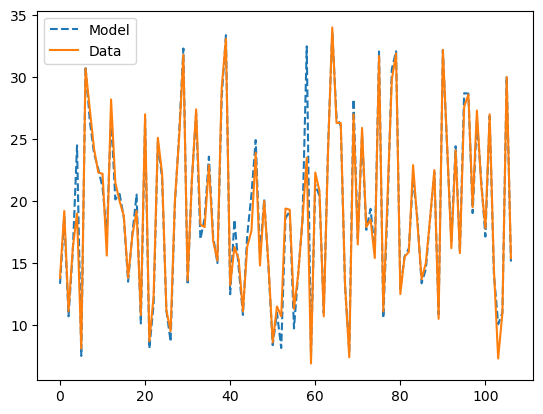

Mean Squared Error: 1.6474744205607503
R-squared: 0.9629993295424678

Feature Importances:
            Feature    Importance
1           MaxTemp  9.879270e-01
9       Humidity3pm  2.926562e-03
14          Temp9am  8.178192e-04
3       Evaporation  7.378611e-04
0           MinTemp  7.139945e-04
..              ...           ...
68   WindDir3pm_nan  7.806752e-07
50   WindDir9am_WSW  6.694859e-07
33  WindGustDir_WSW  6.348769e-07
30   WindGustDir_SW  1.670865e-07
34  WindGustDir_nan  1.604802e-07

[69 rows x 2 columns]


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report


df = pd.read_csv('weather.csv')

# Convert categorical features to numerical
df['RainTomorrow'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1})
df['RainToday'] = df['RainToday'].map({'No': 0, 'Yes': 1})

# Identify the categorical columns you want to one-hot encode
categorical_cols = ['WindGustDir', 'WindDir9am', 'WindDir3pm']

# Create a OneHotEncoder object
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit and transform the categorical columns
encoded_data = encoder.fit_transform(df[categorical_cols])

# Get the feature names for the new encoded columns
feature_names = encoder.get_feature_names_out(categorical_cols)

# Create a new DataFrame with the one-hot encoded data
encoded_df = pd.DataFrame(encoded_data, columns=feature_names)

# Concatenate the one-hot encoded DataFrame with the original DataFrame
df_encoded = pd.concat([df.drop(categorical_cols, axis=1), encoded_df], axis=1)

# Separate features (X) and target (y)
X = df_encoded.drop(columns = ['Temp3pm'])# all columns except the rain tmr
y = df_encoded['Temp3pm'] # last

# Handle missing values
X = X.dropna()
y = y.loc[X.index] # y only has rows corresponding to row indices of X

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print('y_pred = ' , y_pred)
print('y_test = ' , y_test.to_numpy())
plt.plot(y_pred, '--', label='Model')
plt.plot(y_test.to_numpy(), label='Data')
plt.legend()
plt.show()

# Evaluate the regression model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
# Get feature importances
importances = model.feature_importances_
# Create a DataFrame to store feature names and their importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
# Sort the DataFrame by importance in descending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
# Print the feature importances
print("\nFeature Importances:")
print(feature_importances)

# Neural Operators

In [1]:
from neuralop.training import Trainer
from neuralop.models import FNO
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

# Dataset Preparation
class WeatherTensorDataset(Dataset):          # This class is a custom dataset loader that will load preprocessed
    def __init__(self, data_path):            # weather data (saved as a .pt file) into PyTorch’s data pipeline.
        self.samples = torch.load(data_path)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        #return {'x': input_tensor, 'y': target_tensor}  # (input, target)              I don't think this line was right, delete?
        return {'x': self.samples[idx][0], 'y': self.samples[idx][1]}

In [6]:
# Load and clean the CSV file
df = pd.read_csv('data2022/accum_data.csv')

# Grid creation
times = sorted(df['valid_time'].unique()) # Get unique times

input_vars = ['u10', 'v10', 'surface_pressure', 'u10n', 'v10n']
output_var = 'surface_temperature'

grids = []

# Process the data for each time step
for time in tqdm(times):   # tqdm(times) progress bar for visualization
    slice_df = df[df['valid_time'] == time] # Get data for the current time step

    lat_vals = sorted(slice_df['latitude'].unique()) # Unique lat
    lon_vals = sorted(slice_df['longitude'].unique()) # Unique long

    H = len(lat_vals) # Height (number of latitude values)
    W = len(lon_vals)  # Width (number of longitude values)

    # Build 2D grid for each input variable
    input_channels = []
    for var in input_vars:
        pivot = slice_df.pivot(index='latitude', columns='longitude', values=var)
        grid = pivot.to_numpy() # Creates a 2D grid using pandas
        input_channels.append(grid)

    # Build target grid
    target_pivot = slice_df.pivot(index='latitude', columns='longitude', values=output_var)
    target_grid = target_pivot.to_numpy()

    # Stack into tensors
    input_tensor = torch.tensor(np.stack(input_channels), dtype=torch.float32)  # Shape: [C, H, W]  (C is the # of input variables, H is the # of lat points, and W is the # of long points)
    target_tensor = torch.tensor(target_grid[np.newaxis, :, :], dtype=torch.float32)  # Shape: [1, H, W]

    grids.append((input_tensor, target_tensor))

# Save the dataset to a file
torch.save(grids, 'weather_dataset.pt')  # List of (input, target) pairs

100%|███████████████████████████████████████| 1460/1460 [00:35<00:00, 40.70it/s]


In [7]:
# Dataset Splitting
full_dataset = WeatherTensorDataset('weather_dataset.pt')
train_size = int(0.8 * len(full_dataset)) #80% for train
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Model Setup
in_channels = 5 # # of input
out_channels = 1 # # of output

# Initialize the model
model = FNO(n_modes=(12, 12), hidden_channels=32, in_channels=in_channels, out_channels=out_channels)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Initialize optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Adam optimizer with learning rate 0.001
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) # Learning rate scheduler

# Training Setup
trainer = Trainer(model=model, n_epochs=10, device=device)

# Wrap the test_loader in a dictionary
test_loaders = {'test': test_loader}

In [3]:
# Train the model
#trainer.train(train_loader, test_loaders, optimizer, scheduler)

In [4]:
folder = 'data2022/'
dfs = [pd.read_csv(folder+file) for file in ('accum_data.csv', 'instantaneous_data.csv', 'max_data.csv')]
[print(df.shape) for df in dfs]
dff = pd.concat(dfs,axis=1)
dff.shape, dff.head()

(197100, 10)
(197100, 10)
(197100, 10)


((197100, 30),
             valid_time  latitude  longitude       u10       v10  \
 0  2022-01-01 03:00:00      41.0     -109.0  0.694458 -0.103119   
 1  2022-01-01 03:00:00      41.0     -108.5  0.498169  0.364655   
 2  2022-01-01 03:00:00      41.0     -108.0 -0.283081  0.928131   
 3  2022-01-01 03:00:00      41.0     -107.5 -1.179565  1.212311   
 4  2022-01-01 03:00:00      41.0     -107.0 -0.895386  0.902740   
 
    surface_dewpoint  surface_temperature  surface_pressure      u10n  \
 0         261.02032            262.44580           77215.0  0.223984   
 1         260.49298            261.94580           77910.0  0.170273   
 2         260.55157            262.17627           77852.0 -0.130508   
 3         259.16290            261.19970           75851.0 -0.657852   
 4         258.49884            260.38330           73532.0 -0.682266   
 
        v10n  ...           valid_time  latitude  longitude       u10  \
 0  0.018707  ...  2022-01-01 03:00:00      41.0     -109.0  0

In [7]:
df_sorted = dfs[1].groupby(['valid_time','latitude','longitude']).agg(lambda x:x)

In [8]:
[group.pivot(index='latitude', columns='longitude', 
             values=['u10', 'v10', 'surface_dewpoint', 'surface_temperature', 'surface_pressure', 'u10n', 'v10n'])
 for _, group in dfs[1].groupby(['valid_time'])][0].T


latitude            37.0      37.5      38.0      38.5      39.0      39.5  \
     longitude                                                               
u10  -109.0     0.801880  0.497192  0.071411  0.252075 -0.784058 -1.430542   
     -108.5     0.364380  0.071411  0.498169  0.855591 -0.354370 -1.091675   
     -108.0    -0.715698 -0.036987  1.027466  1.060669  0.084106 -0.411987   
     -107.5    -0.524292  0.555786  1.306763  1.032349  0.590942  0.215942   
     -107.0     0.089966  1.087036  1.072388  1.101685  1.027466  0.724731   
...                  ...       ...       ...       ...       ...       ...   
v10n -104.0     2.508942 -0.862152 -4.950043 -7.416840 -5.509613 -3.632660   
     -103.5     3.095856 -1.234222 -5.412933 -7.416840 -6.391449 -4.229340   
     -103.0     2.418121 -1.999847 -5.101410 -6.658050 -6.350433 -4.705902   
     -102.5     1.463043 -2.343597 -5.061371 -5.993011 -6.081879 -4.845550   
     -102.0    -0.115082 -3.473480 -5.395355 -6.110199 -5.892425 -5.337738   

latitude            40.0      40.5      41.0  
     longitude                                
u10  -109.0    -1.301636 -0.386597  0.694458  
     -108.5    -1.436401 -0.661987  0.498169  
     -108.0    -1.176636 -0.729370 -0.283081  
     -107.5    -0.873901 -1.517456 -1.179565  
     -107.0     0.013794 -0.879761 -0.895386  
...                  ...       ...       ...  
v10n -104.0    -2.436371 -2.205902 -1.886566  
     -103.5    -3.119965 -2.894379 -2.670746  
     -103.0    -3.897308 -3.553558 -3.447113  
     -102.5    -4.495941 -4.395355 -4.130707  
     -102.0    -5.339691 -5.312347 -5.022308  

[105 rows x 9 columns]

## Second Go Round

In [42]:
from itertools import pairwise

tensors = [t[0] for t in grids]
data_block = torch.stack(tensors, stackdim:=1)
chunks = data_block.split(20,stackdim)
torch.save(tuple(pairwise(chunks)), 'weather_chunks.pt')

# Dataset Splitting
full_dataset = WeatherTensorDataset('weather_chunks.pt')

train_size = int(0.8 * len(full_dataset)) #80% for train
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

train_dataset[0]['x'].shape # C x T x H x W, where T is the number of observation times

torch.Size([5, 20, 9, 15])

In [43]:
# Model Setup
in_channels = len(input_vars) # # of input
out_channels = len(output_vars:=input_vars) # # of output

# Initialize the model
model = FNO(n_modes=(12, 12, 12), hidden_channels=32, in_channels=in_channels, out_channels=out_channels)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Initialize optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Adam optimizer with learning rate 0.001
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) # Learning rate scheduler

# Training Setup
trainer = Trainer(model=model, n_epochs=10, eval_interval=5, device=device, verbose=True)

# Wrap the test_loader in a dictionary
test_loaders = {'test': test_loader}

trainer.train(train_loader, test_loaders, optimizer, scheduler)

Training on 57 samples
Testing on [15] samples         on resolutions ['test'].
Raw outputs of shape torch.Size([1, 5, 20, 9, 15])
[0] time=17.37, avg_loss=2155.7140, train_err=2155.7140
Eval: test_l2=581.3284
[5] time=16.71, avg_loss=264.4928, train_err=264.4928
Eval: test_l2=168.7204


{'train_err': 208.9028201186866,
 'avg_loss': 208.9028201186866,
 'avg_lasso_loss': None,
 'epoch_train_time': 16.77825275699979}

In [44]:
#torch.save(model.state_dict(), 'MondayMorningModel.pt')

In [46]:
model.forward(test_dataset[0]['x'][:,-1,:,:].unsqueeze(0).unsqueeze(0))

RuntimeError: Given groups=1, weight of size [64, 8, 1], expected input[1, 4, 675] to have 8 channels, but got 4 channels instead

In [55]:
out = model(test_dataset[0]['x'].unsqueeze(0))
prediction = out.squeeze()[2,:,1,1]
test = test_dataset[0]['y'][2,:,1,1]
prediction,test

(tensor([3103.1250, 3105.5190, 3128.3618, 3137.9329, 3136.9014, 3131.4380,
         3141.0750, 3135.9158, 3130.0901, 3117.6890, 3126.0916, 3128.9338,
         3122.9734, 3111.7693, 3117.8486, 3119.5728, 3124.4333, 3124.2344,
         3138.3450, 3138.8315], grad_fn=<SelectBackward0>),
 tensor([78368.9375, 78501.1875, 78720.1875, 78562.4375, 78514.8750, 78504.5000,
         78673.2500, 78487.8125, 78263.5625, 78130.5000, 78081.0000, 77709.0000,
         77457.5625, 77330.0000, 77300.6875, 77135.3750, 77193.7500, 77416.5625,
         77623.8750, 77686.8125]))